MovieWriter ffmpeg unavailable; using Pillow instead.


1


ValueError: unknown file extension: .mp4

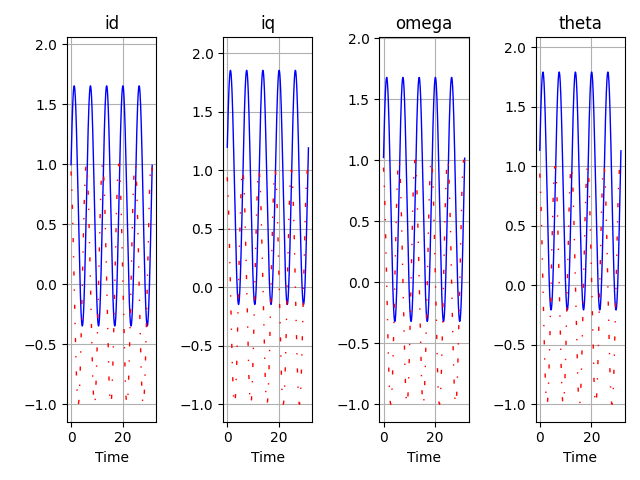

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from numba import cuda, jit
from IPython.display import display
from ipywidgets import interactive
import ipywidgets as widgets
from matplotlib import rc
# equivalent to rcParams['animation.html'] = 'html5'
# rc('animation', html='html5')
from IPython.display import HTML, Javascript
from ipywidgets import IntSlider, Video
from IPython.display import Video
from IPython.display import clear_output


linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),
     ('long dash with offset', (5, (10, 3))),
     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]





simTime = 1
x = np.linspace(0, simTime, int(simTime/1e3))
x = np.arange(0, 10*np.pi, 0.01)
simTime =  x[-1]
# fig = plt.figure(figsize=(15,10))
fig = plt.figure()

num_subplots = 4
nrows = int(num_subplots/4)
ncols =int(4/int(num_subplots/4))
ax = [None]*num_subplots
line1 = [None]*num_subplots
line2 = [None]*num_subplots
label1 = ['id', 'iq', 'omega', 'theta', 'id_dot', 'iq_dot', 'omega_dot', 'theta_dot', 'id_error', 'iq_error', 'omega_error', 'vd', 'T_elec', 'lambda_d', 'reward', 'vq']
label2 = ['id_ref', 'iq_ref', 'omega_ref', 'theta_ref', '_', '_', '_', '_', '_', '_', '_', '_', 'T_load', 'lambda_q', '_', '_']

for i in range(num_subplots):
    # create axes
    ax[i] = plt.subplot(nrows,ncols,i+1, autoscale_on=True)
    ax[i].set_xlim(( 0, simTime))       
    # ax[i].set_ylim()
    ax[i].set_xlabel('Time') if i>=(num_subplots-4) else ax[i].tick_params('x', labelbottom=False)
    # ax[i].set_ylabel('Magnitude') l
    ax[i].set_title(label1[i])
    # ax[i].legend([label1[i], label2[i]])
    ax[i].grid(True)# create objects that will change in the animation. These are initially empty, and will be given new values for each frame in the animation.
    ax[i].autoscale(enable=True)
plt.tight_layout()
# plt.close()

ims = []

#implement skipping

for j in range(1000):
    if j%60==0:
        for i in range(num_subplots): #plot data
            line1[i], = ax[i].plot(x, np.random.rand(1)+np.sin(x+j/50), color='blue', lw=1, animated=True)     # ax.plot returns a list of 2D line objects
            line2[i], = ax[i].plot(x, np.cos(x+j/50),  linestyle=(0, (3, 10, 1, 10)), color='red', lw=1, animated=True)
        ims.append(tuple(line1 + line2))
        # plt.show(ims[-1])
    else: 
        pass

@jit(forceobj=True, parallel=True)
def do_anim(n):
    print(n['new'])
    anim = animation.ArtistAnimation(fig, ims, interval=100*n['new'], blit=True, repeat_delay=1000, repeat=True).save(f"movie.mp4")
    HTML(anim.to_html5_video())

animate = IntSlider(description='animate')
animate.observe(do_anim, 'value')
# display(animate)


do_anim({'new':1})
anim = animation.ArtistAnimation(fig, ims, interval=100*1, blit=True, repeat_delay=1000, repeat=True)
HTML(anim.to_html5_video())



In [2]:
for i in range(1,5):
    animate.value = f'{i}'
    anim = animation.ArtistAnimation(fig, ims, interval=100*1, blit=True, repeat_delay=1000, repeat=True)
    display(HTML(anim.to_html5_video()))

    # clear_output()
    # display(Video("movie.mp4", width=400))

1
2
3
4


TypeError: 'AxesSubplot' object is not callable

### A.3.3.4 Step 4. Render the Animation

The final step is to actually render and display the desired animation. This is the compute-intensive step in the procedure. The next cell imports `HTML` which is used to display a HTML elements created in a python script. The animation is rendered to html5 video with the `to_html5_video()` function and then displayed with `HTML()`.

In [ ]:
# from IPython.display import HTML
HTML(anim.to_html5_video())
# equivalent to rcParams['animation.html'] = 'html5'
# rc('animation', html='html5')

An alternative to the use of HTML is to set the default rendering of an animation object. 

Once the default rendering of the animation object is set to html5, all you have to do is ask to display the animation object. Everything is then done behind the scenes to render and display the desired animation.

## A.3.4 Example: Phase Plane Animation for an Exothermic Stirred-Tank Reactor

This is more complex example that demonstrates the complex dynamics of an exothermic continuous stirred-tank reactor when operated with an unstable steady state. The computational strategy is to compute solutions to the dynamical model for a set of initial conditions, then step through the solutions simulataneously to draw frames in the animation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.integrate import odeint

from matplotlib import animation
from IPython.display import HTML

# mode parameteres
Ea  = 72750     # activation energy J/gmol
R   = 8.314     # gas constant J/gmol/K
k0  = 7.2e10    # Arrhenius rate constant 1/min
V   = 100.0     # Volume [L]
rho = 1000.0    # Density [g/L]
Cp  = 0.239     # Heat capacity [J/g/K]
dHr = -5.0e4    # Enthalpy of reaction [J/mol]
UA  = 5.0e4     # Heat transfer [J/min/K]
q = 100.0       # Flowrate [L/min]
cAi = 1.0       # Inlet feed concentration [mol/L]
Ti  = 350.0     # Inlet feed temperature [K]
cA0 = 0.5;      # Initial concentration [mol/L]
T0  = 350.0;    # Initial temperature [K]
Tc  = 305.0     # Coolant temperature [K]

# Arrhenius rate expression
def k(T):
    return k0*np.exp(-Ea/R/T)

def deriv(y,t):
    cA,T = y
    dcA = (q/V)*(cAi - cA) - k(T)*cA
    dT = (q/V)*(Ti - T) + (-dHr/rho/Cp)*k(T)*cA + (UA/V/rho/Cp)*(Tc-T)
    return [dcA,dT]

# create a set of initial conditions
ICs = [[cA0,T0] for cA0 in [0] for T0 in np.linspace(295,480,19)]
ICs += [[cA0,T0] for cA0 in np.linspace(0,1,21) for T0 in [290]]
ICs += [[cA0,T0] for cA0 in [1] for T0 in np.linspace(295,475,18)]

# perform simulations for each of the initial conditions
t = np.linspace(0,10.0,800)
sols = [odeint(deriv,IC,t) for IC in ICs]

# create background figure and axes
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((0,1))
ax.set_ylim((290,480))
ax.set_xlabel('Concentration [gmol/liter]')
ax.set_ylabel('Temperature [K]')
ax.set_title('Exothermic Reactor with Tc = {0:.1f} K'.format(Tc))

# create lists of colors, points, and lines
colors = sns.color_palette("husl",len(sols))
pts = sum([ax.plot([],[],'o',color=colors[k],ms=15) for k in range(0,len(sols))],[])
lines = sum([ax.plot([],[],color=colors[k],lw=2) for k in range(0,len(sols))],[])

# don't show the plain background
plt.close()

# define function to draw each frame
def drawframe(n):
    for k in range(0,len(sols)):
        C,T = sols[k].T
        pts[k].set_data(C[n],T[n])
        lines[k].set_data(C[:n],T[:n])
    return pts + lines

# create animiation object and render in HTML video
anim = animation.FuncAnimation(fig, drawframe, frames=len(t), interval=20, blit=True)
HTML(anim.to_html5_video())

In [2]:
for _ in range(10):
    # create animiation object and render in HTML video
    anim = animation.FuncAnimation(fig, drawframe, frames=len(t), interval=20, blit=True)
    HTML(anim.to_html5_video())